<a href="https://colab.research.google.com/github/sachin886x/deep-learning-lab/blob/main/lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1650


Using device: cuda
GPU: NVIDIA GeForce GTX 1650
Loading data...
Train: 8000 | Val: 1000 | Test: 1000
Src vocab: 2319 | Tgt vocab: 2972

  Training: vanilla_lstm
  Epoch 01 | Train: 5.2865 | Val: 4.8076 | PPL: 122.43
  Epoch 02 | Train: 4.9804 | Val: 4.7902 | PPL: 120.33
  Epoch 03 | Train: 4.8216 | Val: 4.6030 | PPL: 99.78
  Epoch 04 | Train: 4.6105 | Val: 4.4554 | PPL: 86.09
  Epoch 05 | Train: 4.4245 | Val: 4.3400 | PPL: 76.70
  Epoch 06 | Train: 4.2271 | Val: 4.2044 | PPL: 66.98
  Epoch 07 | Train: 4.0316 | Val: 4.1016 | PPL: 60.44
  Epoch 08 | Train: 3.8385 | Val: 4.0410 | PPL: 56.88
  Epoch 09 | Train: 3.6590 | Val: 3.9843 | PPL: 53.75
  Epoch 10 | Train: 3.4792 | Val: 3.9454 | PPL: 51.70
  Epoch 11 | Train: 3.3151 | Val: 3.9004 | PPL: 49.42
  Epoch 12 | Train: 3.1403 | Val: 3.8926 | PPL: 49.04
  Epoch 13 | Train: 2.9765 | Val: 3.8547 | PPL: 47.21
  Epoch 14 | Train: 2.8095 | Val: 3.8955 | PPL: 49.18
  Epoch 15 | Train: 2.6641 | Val: 3.8744 | PPL: 48.16
  Epoch 16 | Train: 2.5087 

C:\Users\Sachin Prajapati\AppData\Local\Temp\ipykernel_15768\3426694534.py:351: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + src_tokens, rotation=45, ha="left", fontsize=9)
C:\Users\Sachin Prajapati\AppData\Local\Temp\ipykernel_15768\3426694534.py:352: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + tgt_tokens, fontsize=9)


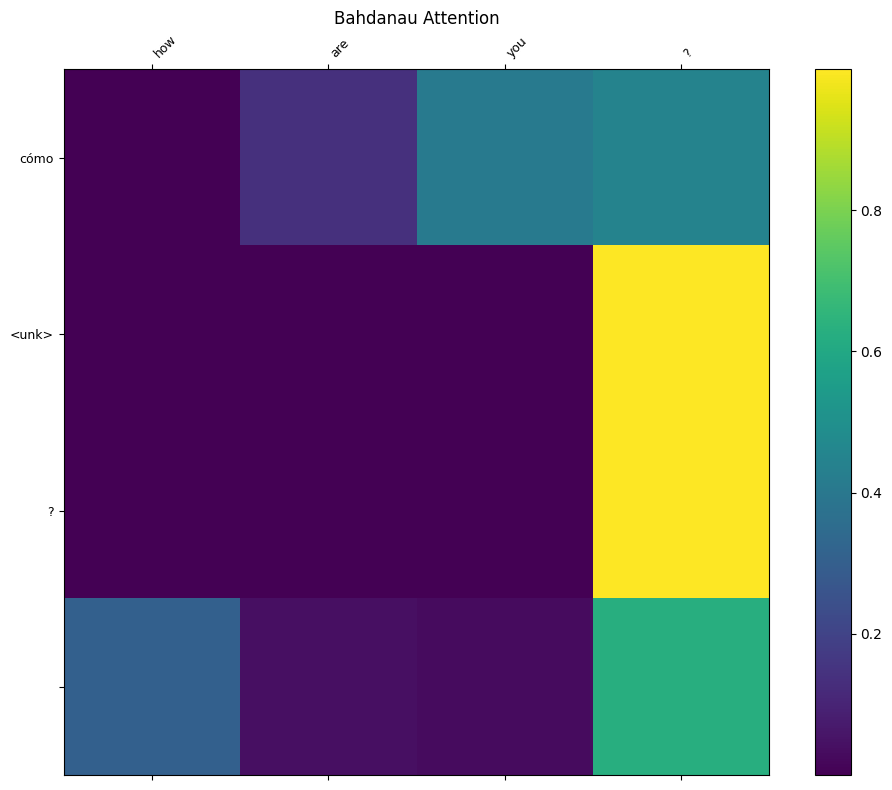

Saved: Bahdanau_Attention.png


C:\Users\Sachin Prajapati\AppData\Local\Temp\ipykernel_15768\3426694534.py:351: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + src_tokens, rotation=45, ha="left", fontsize=9)
C:\Users\Sachin Prajapati\AppData\Local\Temp\ipykernel_15768\3426694534.py:352: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + tgt_tokens, fontsize=9)


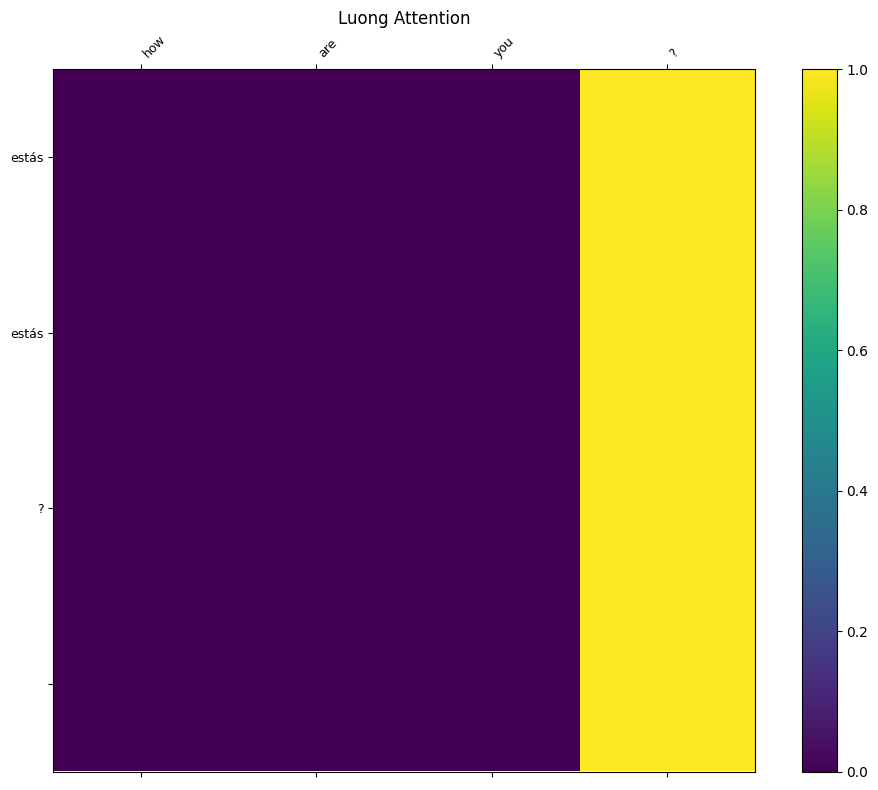

Saved: Luong_Attention.png


In [ ]:
"""
Sequence-to-Sequence Learning with LSTM
English-to-Spanish Machine Translation
- Part 1: LSTM Encoder-Decoder (No Attention)
- Part 2: Bahdanau (Additive) Attention
- Part 2: Luong (Multiplicative) Attention
CUDA-ready implementation
"""

import math, time, random, re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ─────────────────────────────────────────────
# 0. Config
# ─────────────────────────────────────────────
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

DATA_PATH   = "spa.txt"
MAX_SAMPLES = 10_000
MAX_LEN     = 50
MIN_FREQ    = 2
BATCH_SIZE  = 64
EMBED_DIM   = 256
HIDDEN_DIM  = 512
N_LAYERS    = 2
DROPOUT     = 0.3
EPOCHS      = 20
LR          = 1e-3
CLIP        = 1.0

PAD, SOS, EOS, UNK = "<pad>", "<sos>", "<eos>", "<unk>"
PAD_IDX = 0

# ─────────────────────────────────────────────
# 1. Data
# ─────────────────────────────────────────────
def tokenize(s):
    return re.findall(r"\w+|[^\w\s]", s.lower())

def load_pairs(path, max_samples=MAX_SAMPLES):
    pairs = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                pairs.append((parts[0], parts[1]))
    random.shuffle(pairs)
    return pairs[:max_samples]

class Vocab:
    def __init__(self, token_list, min_freq=MIN_FREQ):
        counter = Counter(token_list)
        self.itos = [PAD, SOS, EOS, UNK] + [t for t, c in counter.items() if c >= min_freq]
        self.stoi = {t: i for i, t in enumerate(self.itos)}
    def __len__(self): return len(self.itos)
    def encode(self, tokens):
        return [self.stoi.get(t, self.stoi[UNK]) for t in tokens]

def build_vocabs(pairs):
    src_tok = [t for en, _ in pairs for t in tokenize(en)]
    tgt_tok = [t for _, es in pairs for t in tokenize(es)]
    return Vocab(src_tok), Vocab(tgt_tok)

class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab):
        self.samples = []
        for en, es in pairs:
            src = src_vocab.encode(tokenize(en))[:MAX_LEN]
            tgt = tgt_vocab.encode(tokenize(es))[:MAX_LEN]
            self.samples.append((src, tgt))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i): return self.samples[i]

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    def pad(seqs, prepend=None, append=None):
        seqs = [([prepend] if prepend is not None else []) + list(s) +
                ([append]  if append  is not None else []) for s in seqs]
        ml = max(len(s) for s in seqs)
        return torch.tensor([s + [PAD_IDX]*(ml-len(s)) for s in seqs], dtype=torch.long)
    src     = pad(src_batch)
    tgt_in  = pad(tgt_batch, prepend=1)   # <sos> + tokens
    tgt_out = pad(tgt_batch, append=2)    # tokens + <eos>
    return src, tgt_in, tgt_out

# ─────────────────────────────────────────────
# 2. PART 1 — Vanilla LSTM Encoder-Decoder
# ─────────────────────────────────────────────
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embed   = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm    = nn.LSTM(embed_dim, hidden_dim, n_layers,
                               batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        emb = self.dropout(self.embed(src))
        outputs, (h, c) = self.lstm(emb)
        return outputs, h, c

class VanillaDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embed   = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm    = nn.LSTM(embed_dim, hidden_dim, n_layers,
                               batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc_out  = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, h, c):
        emb = self.dropout(self.embed(tgt))
        out, (h, c) = self.lstm(emb, (h, c))
        pred = self.fc_out(out.squeeze(1))
        return pred, h, c

class VanillaSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing=0.5):
        B, T = tgt.shape
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(B, T, vocab_size).to(src.device)
        _, h, c = self.encoder(src)
        inp = tgt[:, 0:1]
        for t in range(1, T):
            pred, h, c = self.decoder(inp, h, c)
            outputs[:, t] = pred
            inp = tgt[:, t:t+1] if random.random() < teacher_forcing else pred.argmax(1).unsqueeze(1)
        return outputs

# ─────────────────────────────────────────────
# 3. PART 2a — Bahdanau (Additive) Attention
# ─────────────────────────────────────────────
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.V  = nn.Linear(hidden_dim, 1)

    def forward(self, h, enc_outputs):
        # h: (B,H)  enc_outputs: (B,L,H)
        score   = self.V(torch.tanh(self.W1(enc_outputs) + self.W2(h).unsqueeze(1)))  # (B,L,1)
        weights = F.softmax(score, dim=1)                                              # (B,L,1)
        context = (weights * enc_outputs).sum(dim=1)                                   # (B,H)
        return context, weights.squeeze(2)

class BahdanauDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embed     = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.attention = BahdanauAttention(hidden_dim)
        self.lstm      = nn.LSTM(embed_dim + hidden_dim, hidden_dim, n_layers,
                                 batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc_out    = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, tgt, h, c, enc_outputs):
        emb = self.dropout(self.embed(tgt))
        context, attn_w = self.attention(h[-1], enc_outputs)
        lstm_in = torch.cat([emb, context.unsqueeze(1)], dim=2)
        out, (h, c) = self.lstm(lstm_in, (h, c))
        pred = self.fc_out(torch.cat([out.squeeze(1), context], dim=1))
        return pred, h, c, attn_w

class BahdanauSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing=0.5):
        B, T = tgt.shape
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(B, T, vocab_size).to(src.device)
        attns   = torch.zeros(B, T, src.size(1)).to(src.device)
        enc_out, h, c = self.encoder(src)
        inp = tgt[:, 0:1]
        for t in range(1, T):
            pred, h, c, attn_w = self.decoder(inp, h, c, enc_out)
            outputs[:, t] = pred
            attns[:, t]   = attn_w
            inp = tgt[:, t:t+1] if random.random() < teacher_forcing else pred.argmax(1).unsqueeze(1)
        return outputs, attns

# ─────────────────────────────────────────────
# 4. PART 2b — Luong (Multiplicative) Attention
# ─────────────────────────────────────────────
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim, method="general"):
        super().__init__()
        self.method = method
        if method == "general":
            self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)
        elif method == "concat":
            self.W = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)
            self.V = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, h, enc_outputs):
        # h: (B,H)  enc_outputs: (B,L,H)
        if self.method == "dot":
            score = torch.bmm(enc_outputs, h.unsqueeze(2)).squeeze(2)
        elif self.method == "general":
            score = torch.bmm(enc_outputs, self.W(h).unsqueeze(2)).squeeze(2)
        elif self.method == "concat":
            h_exp = h.unsqueeze(1).expand_as(enc_outputs)
            score = self.V(torch.tanh(self.W(torch.cat([enc_outputs, h_exp], dim=2)))).squeeze(2)
        weights = F.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), enc_outputs).squeeze(1)
        return context, weights

class LuongDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout, method="general"):
        super().__init__()
        self.embed     = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm      = nn.LSTM(embed_dim, hidden_dim, n_layers,
                                 batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.attention = LuongAttention(hidden_dim, method)
        self.fc_out    = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, tgt, h, c, enc_outputs):
        emb = self.dropout(self.embed(tgt))
        out, (h, c) = self.lstm(emb, (h, c))
        context, attn_w = self.attention(out.squeeze(1), enc_outputs)
        pred = self.fc_out(torch.cat([out.squeeze(1), context], dim=1))
        return pred, h, c, attn_w

class LuongSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing=0.5):
        B, T = tgt.shape
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(B, T, vocab_size).to(src.device)
        attns   = torch.zeros(B, T, src.size(1)).to(src.device)
        enc_out, h, c = self.encoder(src)
        inp = tgt[:, 0:1]
        for t in range(1, T):
            pred, h, c, attn_w = self.decoder(inp, h, c, enc_out)
            outputs[:, t] = pred
            attns[:, t]   = attn_w
            inp = tgt[:, t:t+1] if random.random() < teacher_forcing else pred.argmax(1).unsqueeze(1)
        return outputs, attns

# ─────────────────────────────────────────────
# 5. Train / Evaluate helpers
# ─────────────────────────────────────────────
def train_epoch(model, loader, optimizer, criterion, has_attn=False):
    model.train()
    total_loss = 0
    for src, tgt_in, tgt_out in loader:
        src, tgt_in, tgt_out = src.to(DEVICE), tgt_in.to(DEVICE), tgt_out.to(DEVICE)
        optimizer.zero_grad()
        out = model(src, tgt_in)[0] if has_attn else model(src, tgt_in)
        loss = criterion(out[:, 1:].reshape(-1, out.size(-1)), tgt_out[:, 1:].reshape(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, has_attn=False):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt_in, tgt_out in loader:
            src, tgt_in, tgt_out = src.to(DEVICE), tgt_in.to(DEVICE), tgt_out.to(DEVICE)
            out = model(src, tgt_in, teacher_forcing=0)[0] if has_attn else model(src, tgt_in, teacher_forcing=0)
            loss = criterion(out[:, 1:].reshape(-1, out.size(-1)), tgt_out[:, 1:].reshape(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

# ─────────────────────────────────────────────
# 6. Greedy Decode
# ─────────────────────────────────────────────
def translate(model, sentence, src_vocab, tgt_vocab, has_attn=False, max_len=MAX_LEN):
    model.eval()
    with torch.no_grad():
        tokens = tokenize(sentence)
        src = torch.tensor([src_vocab.encode(tokens)], dtype=torch.long).to(DEVICE)
        enc_out, h, c = model.encoder(src)
        tgt_ids = [tgt_vocab.stoi[SOS]]
        attn_weights = []
        for _ in range(max_len):
            inp = torch.tensor([[tgt_ids[-1]]], dtype=torch.long).to(DEVICE)
            if has_attn:
                pred, h, c, attn_w = model.decoder(inp, h, c, enc_out)
                attn_weights.append(attn_w.squeeze(0).cpu().numpy())
            else:
                pred, h, c = model.decoder(inp, h, c)
            next_id = pred.argmax(1).item()
            tgt_ids.append(next_id)
            if next_id == tgt_vocab.stoi[EOS]:
                break
        translated = [tgt_vocab.itos[i] for i in tgt_ids[1:-1]]
        return " ".join(translated), tokens, attn_weights

# ─────────────────────────────────────────────
# 7. BLEU Score
# ─────────────────────────────────────────────
def compute_bleu(model, pairs, src_vocab, tgt_vocab, has_attn=False, n=200):
    refs, hyps = [], []
    for en, es in random.sample(pairs, min(n, len(pairs))):
        ref = tokenize(es)
        hyp_str, _, _ = translate(model, en, src_vocab, tgt_vocab, has_attn)
        refs.append(ref)
        hyps.append(hyp_str.split())
    scores = []
    for ngram in range(1, 5):
        match, total = 0, 0
        for ref, hyp in zip(refs, hyps):
            rc = Counter(tuple(ref[i:i+ngram]) for i in range(max(0, len(ref)-ngram+1)))
            hg = [tuple(hyp[i:i+ngram]) for i in range(max(0, len(hyp)-ngram+1))]
            for g in hg:
                if rc.get(g, 0) > 0:
                    match += 1; rc[g] -= 1
            total += len(hg)
        scores.append(match / total if total > 0 else 0)
    bp = min(1.0, sum(len(h) for h in hyps) / max(1, sum(len(r) for r in refs)))
    return bp * math.exp(sum(math.log(s+1e-10) for s in scores) / 4) * 100

# ─────────────────────────────────────────────
# 8. Attention Visualization
# ─────────────────────────────────────────────
def plot_attention(src_tokens, tgt_tokens, attn_weights, title="Attention"):
    if not attn_weights:
        print("No attention weights to plot.")
        return
    attn = np.array(attn_weights)
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.matshow(attn, cmap="viridis")
    plt.colorbar(im)
    ax.set_xticklabels([""] + src_tokens, rotation=45, ha="left", fontsize=9)
    ax.set_yticklabels([""] + tgt_tokens, fontsize=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(title)
    plt.tight_layout()
    fname = title.replace(" ", "_") + ".png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print(f"Saved: {fname}")

# ─────────────────────────────────────────────
# 9. Training Runner
# ─────────────────────────────────────────────
def run_training(model, name, train_loader, val_loader, has_attn=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)
    best_val, best_path = float("inf"), f"best_{name}.pt"

    print(f"\n{'='*55}")
    print(f"  Training: {name}")
    print(f"{'='*55}")
    t0 = time.time()

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, has_attn)
        val_loss   = evaluate(model, val_loader, criterion, has_attn)
        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), best_path)
        print(f"  Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | PPL: {math.exp(val_loss):.2f}")

    elapsed = time.time() - t0
    print(f"  Training time: {elapsed/60:.1f} min")
    model.load_state_dict(torch.load(best_path, map_location=DEVICE))
    return model, elapsed

# ─────────────────────────────────────────────
# 10. Main
# ─────────────────────────────────────────────
if __name__ == "__main__":

    # ── Data ──
    print("Loading data...")
    pairs = load_pairs(DATA_PATH)
    n = len(pairs)
    train_pairs = pairs[:int(0.8*n)]
    val_pairs   = pairs[int(0.8*n):int(0.9*n)]
    test_pairs  = pairs[int(0.9*n):]
    print(f"Train: {len(train_pairs)} | Val: {len(val_pairs)} | Test: {len(test_pairs)}")

    src_vocab, tgt_vocab = build_vocabs(train_pairs)
    print(f"Src vocab: {len(src_vocab)} | Tgt vocab: {len(tgt_vocab)}")

    train_ds = TranslationDataset(train_pairs, src_vocab, tgt_vocab)
    val_ds   = TranslationDataset(val_pairs,   src_vocab, tgt_vocab)
    test_ds  = TranslationDataset(test_pairs,  src_vocab, tgt_vocab)

    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True,  collate_fn=collate_fn, pin_memory=torch.cuda.is_available())
    val_loader   = DataLoader(val_ds,   BATCH_SIZE, shuffle=False, collate_fn=collate_fn, pin_memory=torch.cuda.is_available())
    test_loader  = DataLoader(test_ds,  BATCH_SIZE, shuffle=False, collate_fn=collate_fn, pin_memory=torch.cuda.is_available())

    results = {}

    # ── Part 1: Vanilla LSTM ──
    enc = Encoder(len(src_vocab), EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(DEVICE)
    dec = VanillaDecoder(len(tgt_vocab), EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(DEVICE)
    vanilla = VanillaSeq2Seq(enc, dec).to(DEVICE)
    vanilla, t1 = run_training(vanilla, "vanilla_lstm", train_loader, val_loader, has_attn=False)
    bleu1 = compute_bleu(vanilla, test_pairs, src_vocab, tgt_vocab, has_attn=False)
    results["Vanilla LSTM"] = {"bleu": bleu1, "time": t1}
    print(f"\n  Vanilla LSTM Test BLEU: {bleu1:.2f}")

    # ── Part 2a: Bahdanau Attention ──
    enc2 = Encoder(len(src_vocab), EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(DEVICE)
    bdec = BahdanauDecoder(len(tgt_vocab), EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(DEVICE)
    bahdanau = BahdanauSeq2Seq(enc2, bdec).to(DEVICE)
    bahdanau, t2 = run_training(bahdanau, "bahdanau", train_loader, val_loader, has_attn=True)
    bleu2 = compute_bleu(bahdanau, test_pairs, src_vocab, tgt_vocab, has_attn=True)
    results["Bahdanau Attention"] = {"bleu": bleu2, "time": t2}
    print(f"\n  Bahdanau Test BLEU: {bleu2:.2f}")

    # ── Part 2b: Luong Attention ──
    enc3 = Encoder(len(src_vocab), EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(DEVICE)
    ldec = LuongDecoder(len(tgt_vocab), EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT, method="general").to(DEVICE)
    luong = LuongSeq2Seq(enc3, ldec).to(DEVICE)
    luong, t3 = run_training(luong, "luong", train_loader, val_loader, has_attn=True)
    bleu3 = compute_bleu(luong, test_pairs, src_vocab, tgt_vocab, has_attn=True)
    results["Luong Attention"] = {"bleu": bleu3, "time": t3}
    print(f"\n  Luong Test BLEU: {bleu3:.2f}")

    # ── Comparison Table ──
    print("\n" + "="*55)
    print(f"  {'Model':<25} {'BLEU':>8} {'Train Time':>12}")
    print("="*55)
    for name, v in results.items():
        print(f"  {name:<25} {v['bleu']:>8.2f} {v['time']/60:>10.1f}m")
    print("="*55)

    # ── Sample Translations ──
    test_sents = ["Hello.", "How are you?", "I am fine.", "Good morning.", "Thank you."]
    print("\n--- Sample Translations ---")
    for sent in test_sents:
        t_van, _, _          = translate(vanilla,  sent, src_vocab, tgt_vocab, has_attn=False)
        t_bah, _, _          = translate(bahdanau, sent, src_vocab, tgt_vocab, has_attn=True)
        t_luo, _, _          = translate(luong,    sent, src_vocab, tgt_vocab, has_attn=True)
        print(f"\n  EN       : {sent}")
        print(f"  Vanilla  : {t_van}")
        print(f"  Bahdanau : {t_bah}")
        print(f"  Luong    : {t_luo}")

    # ── Attention Plots ──
    sent = "How are you?"
    t_bah, src_tok, attn_bah = translate(bahdanau, sent, src_vocab, tgt_vocab, has_attn=True)
    plot_attention(src_tok, t_bah.split(), attn_bah, title="Bahdanau Attention")

    t_luo, src_tok, attn_luo = translate(luong, sent, src_vocab, tgt_vocab, has_attn=True)
    plot_attention(src_tok, t_luo.split(), attn_luo, title="Luong Attention")